In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dự đoán biến động giá cổ phiếu với LSTM

## Các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

## Mã cổ phiếu FPT (dự đoán theo phút)

### Pre-process & Explore

- Lấy data.
- Chuyển thời gian về kiểu thích hợp.

In [ ]:
df = pd.read_csv(open('/content/drive/MyDrive/FPT.csv'))
df['Date/Time'] = df['Date/Time'].apply(lambda time: datetime.strptime(time, '%m/%d/%Y %H:%M'))
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,2020-12-22 14:24:00,58.20,58.20,58.20,58.20,27470,0
97402,FPT,2020-12-22 14:25:00,58.20,58.20,58.20,58.20,14820,0
97403,FPT,2020-12-22 14:26:00,58.20,58.20,58.20,58.20,500,0
97404,FPT,2020-12-22 14:29:00,58.10,58.10,58.10,58.10,2500,0


- Kiểm tra duplicated -> không có.

In [ ]:
df.duplicated().any()

False

- Kiểm tra null -> không có.

In [ ]:
df.isnull().values.any()

False

- Kiểm tra dữ liệu hợp lệ (cột High có giá trị cao nhất) -> hợp lệ.

In [ ]:
(df['High'] < df['Low']).any(), (df['High'] < df['Open']).any(), (df['High'] < df['Close']).any()

(False, False, False)

- Xem thông tin và miêu tả thống kê của dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         97406 non-null  object        
 1   Date/Time      97406 non-null  datetime64[ns]
 2   Open           97406 non-null  float64       
 3   High           97406 non-null  float64       
 4   Low            97406 non-null  float64       
 5   Close          97406 non-null  float64       
 6   Volume         97406 non-null  int64         
 7   Open Interest  97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.9+ MB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


- Trực quan giá đóng cửa và thanh khoản theo phút.

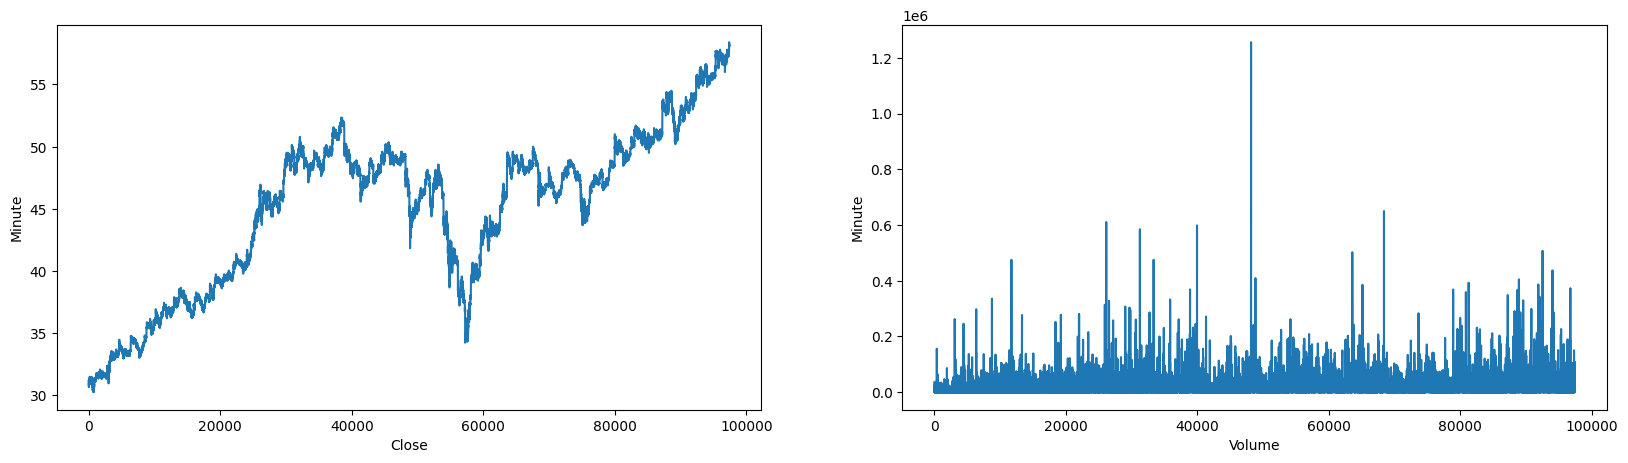

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Close')
plt.ylabel('Minute')
plt.plot(df['Close'])

plt.subplot(1, 2, 2)
plt.xlabel('Volume')
plt.ylabel('Minute')
plt.plot(df['Volume'])

### Modeling

- **Input:** Dữ liệu 60 close price gần nhất.
- **Output:** Close price phút kế tiếp; từ giá cổ phiếu được dự đoán, có thể được dùng làm input tiếp tục dự đoán giá kế tiếp,... sau đó lấy giá dự đoán sau N thời gian (phút, giờ, ngày) trừ cho giá trị hiện tại sẽ được biến động giá cố phiếu.
- **Ý tưởng:** sử dụng LSTM model với dữ liệu 60 phút liên tục để dự đoán giá đóng cửa của phút tiếp theo.

- Scale input và output theo min max.

In [ ]:
# We'll use 'Close' column to predict future prices
feats = ['Close']
data_to_use = df[feats].values

# Data normalization
scaler = MinMaxScaler()
data_to_use = scaler.fit_transform(data_to_use.reshape(-1,len(feats)))
data_to_use

array([[0.02273535],
       [0.01989343],
       [0.01740675],
       ...,
       [0.9928952 ],
       [0.98934281],
       [0.98934281]])

- Split data 8:1:1 cho train:validation:test
- Chuyển dữ liệu thành mảng các chuỗi giá để làm đầu vào cho mô hình
- Mỗi data X sẽ có dạng: số dữ liệu input x 60 (chuỗi các đặt trưng liên tục) x 1.

In [ ]:
# Split data into training and testing sets
def split_dataset(df, test_size=.1):
    return df[:int(df.shape[0]*(1 - test_size))], df[int(df.shape[0]*(1 - test_size)):]

train_data , valid_test_data = split_dataset(data_to_use,test_size=0.2)
valid_data , test_data = split_dataset(valid_test_data,test_size=0.5)

# Convert data into suitable format
def create_dataset(df, len_seq=10):
    x = []
    y = []

    for i in range(len_seq, df.shape[0]):
        x.append(df[i-len_seq:i, -1])
        y.append(df[i,-1])

    x = np.array(x)
    y = np.array(y)

    return x,y

timestep = 60
x_train , y_train = create_dataset(train_data, timestep)
x_valid , y_valid = create_dataset(valid_data, timestep)
x_test , y_test = create_dataset(test_data, timestep)

# Reshape data to fit into LSTM model
x_train = np.reshape(x_train , (x_train.shape[0] , x_train.shape[1] , 1))
x_valid = np.reshape(x_valid , (x_valid.shape[0] , x_valid.shape[1] , 1))
x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))

[[x_train.shape, y_train.shape], [x_valid.shape, y_valid.shape], [x_test.shape, y_test.shape]]

[[(77864, 60, 1), (77864,)],
 [(9681, 60, 1), (9681,)],
 [(9681, 60, 1), (9681,)]]

- Định nghĩa kiến trúc LSTM với dropout giúp ngăn chặn overfitting.
- Tối ưu với adam và loss là MSE.
- Định nghĩa checkpoint lưu model có trọng số tốt nhất.
- Fit model với dữ liệu training, định giá trên dữ liệu validation.

In [ ]:
# Define the LSTM model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(units=128, return_sequences=True))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=64))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define model checkpoint
check_pointer = ModelCheckpoint(filepath='weights_best.hdf5', verbose=2, save_best_only=True)

# Train the model
model.fit(x_train , y_train , epochs=20 , batch_size=32, validation_data=(x_valid, y_valid), callbacks=[check_pointer])

Epoch 1/20
2432/2434 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 1: val_loss improved from inf to 0.00016, saving model to weights_best.hdf5
2434/2434 [==============================] - 26s 9ms/step - loss: 0.0012 - val_loss: 1.5588e-04
Epoch 2/20
  22/2434 [..............................] - ETA: 17s - loss: 5.7049e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2434/2434 [==============================] - ETA: 0s - loss: 3.6106e-04
Epoch 2: val_loss improved from 0.00016 to 0.00009, saving model to weights_best.hdf5
2434/2434 [==============================] - 21s 8ms/step - loss: 3.6106e-04 - val_loss: 9.2618e-05
Epoch 3/20
2434/2434 [==============================] - ETA: 0s - loss: 2.4237e-04
Epoch 3: val_loss improved from 0.00009 to 0.00001, saving model to weights_best.hdf5
2434/2434 [==============================] - 22s 9ms/step - loss: 2.4237e-04 - val_loss: 1.3011e-05
Epoch 4/20
2431/2434 [============================>.] - ETA: 0s - loss: 2.3312e-04
Epoch 4: val_loss did not improve from 0.00001
2434/2434 [==============================] - 21s 9ms/step - loss: 2.3320e-04 - val_loss: 6.2820e-05
Epoch 5/20
2433/2434 [============================>.] - ETA: 0s - loss: 2.2905e-04
Epoch 5: val_loss did not improve from 0.00001
2434/2434 [==============================] - 22s 9ms/step - loss: 2.2906e-04 - val_loss: 2.3834e-05
Epoch 6/20
24

- Tóm tắt kiến trúc model.

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_34 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluating

- Load model tốt nhất và định giá trên tập test, sử dụng RMSE.
- Kết quả RMSE khá nhỏ.

In [ ]:
# Use the model to predict the test data
model = tf.keras.models.load_model('weights_best.hdf5')
y_pred = model.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)

303/303 [==============================] - 2s 4ms/step


0.005769704470352696

- Inverse scale về giá ban đầu và tính RMSE trên giá này.
- RMSE tính được 0.162 tương ứng giá dự đoán lệch với giá thật ~162 đồng.

In [ ]:
# Inverse transform the predicted price data and test data
predicted_price = scaler.inverse_transform(y_pred)
test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

mean_squared_error(test_price, predicted_price, squared=False)

0.16241697221557533

- Trực quan kết quả định giá trên tập test trong 300 phút.
- Kết quả cho khá sát với thực tế.

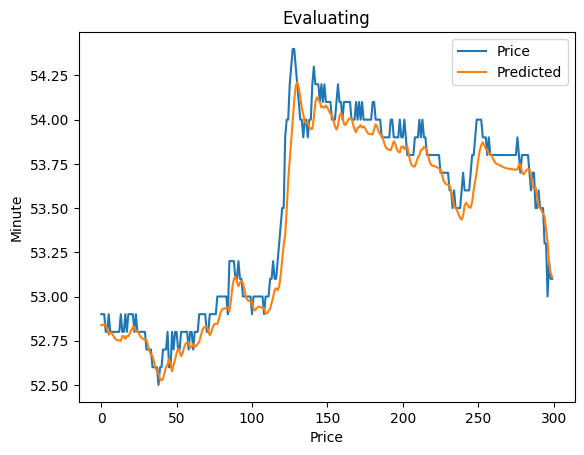

In [ ]:
plt.title('Evaluating')
plt.xlabel('Price')
plt.ylabel('Minute')

plt.plot(test_price[:300], label='Price')
plt.plot(predicted_price[:300], label='Predicted')
plt.legend()

- Biến động giá cổ phiếu sau 5 phút.
    - Trên thực tế giá cổ phiếu giảm 0.1.
    - Model dự đoán giá giảm ~0.14.

In [ ]:
def N_predict(X, N):
    input = X.copy()
    outputs = np.array([])

    for i in tqdm(range(N)):
        output = model.predict(input.reshape(1, timestep, 1), verbose=0)
        outputs = np.append(outputs, output)
        input = np.concatenate((input[1:], output))

    return outputs.reshape(-1, 1)

N = 5
scaler.inverse_transform(N_predict(x_test[0], N))[-1] - test_price[0], test_price[N - 1] - test_price[0]

  0%|          | 0/5 [00:00<?, ?it/s]

(array([-0.13979004]), array([-0.1]))

## Mã cổ phiếu FPT (dự đoán theo giờ)

- Gộp nhóm theo giờ và tạo dataframe mới với:
    - Open là giá của phút đầu tiên theo giờ.
    - High là giá của phút mà cao nhất theo giờ.
    - Low là giá của phút mà thấp nhất theo giờ.
    - Close là giá của phút cuối cùng theo giờ.
    - Volume là tổng thanh khoản theo giờ.

In [ ]:
hour_df = pd.DataFrame(df.groupby([df['Date/Time'].dt.date, df['Date/Time'].dt.hour]).aggregate({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume':'sum'}))
hour_df.index.names = ['Date', 'Hour']
hour_df.reset_index(inplace=True)

hour_df['Date/Hour'] = np.zeros(hour_df.shape[0])
for i in range(hour_df.shape[0]):
    hour_df['Date/Hour'][i] = datetime.combine(hour_df['Date'][i], datetime.min.time()) + pd.Timedelta(hour_df['Hour'][i], 'h')

hour_df.drop(columns=['Date', 'Hour'], inplace=True)
hour_df

<ipython-input-145-d421fe69914e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_df['Date/Hour'][i] = datetime.combine(hour_df['Date'][i], datetime.min.time()) + pd.Timedelta(hour_df['Hour'][i], 'h')


,Open,High,Low,Close,Volume,Date/Hour
0,30.89,30.89,30.59,30.66,84960,2018-12-25 09:00:00
1,31.04,31.22,30.89,31.11,49950,2018-12-26 09:00:00
2,31.19,31.19,31.04,31.07,95330,2018-12-26 10:00:00
3,31.07,31.11,30.96,30.96,37300,2018-12-26 11:00:00
4,30.96,31.04,30.89,31.04,61280,2018-12-26 13:00:00
...,...,...,...,...,...,...
2486,57.40,57.70,57.20,57.50,340240,2020-12-22 09:00:00
2487,57.50,57.50,57.30,57.40,358010,2020-12-22 10:00:00
2488,57.50,57.80,57.30,57.40,359420,2020-12-22 11:00:00
2489,57.50,58.00,57.50,58.00,890850,2020-12-22 13:00:00


- Trực quan giá và thanh khoản.

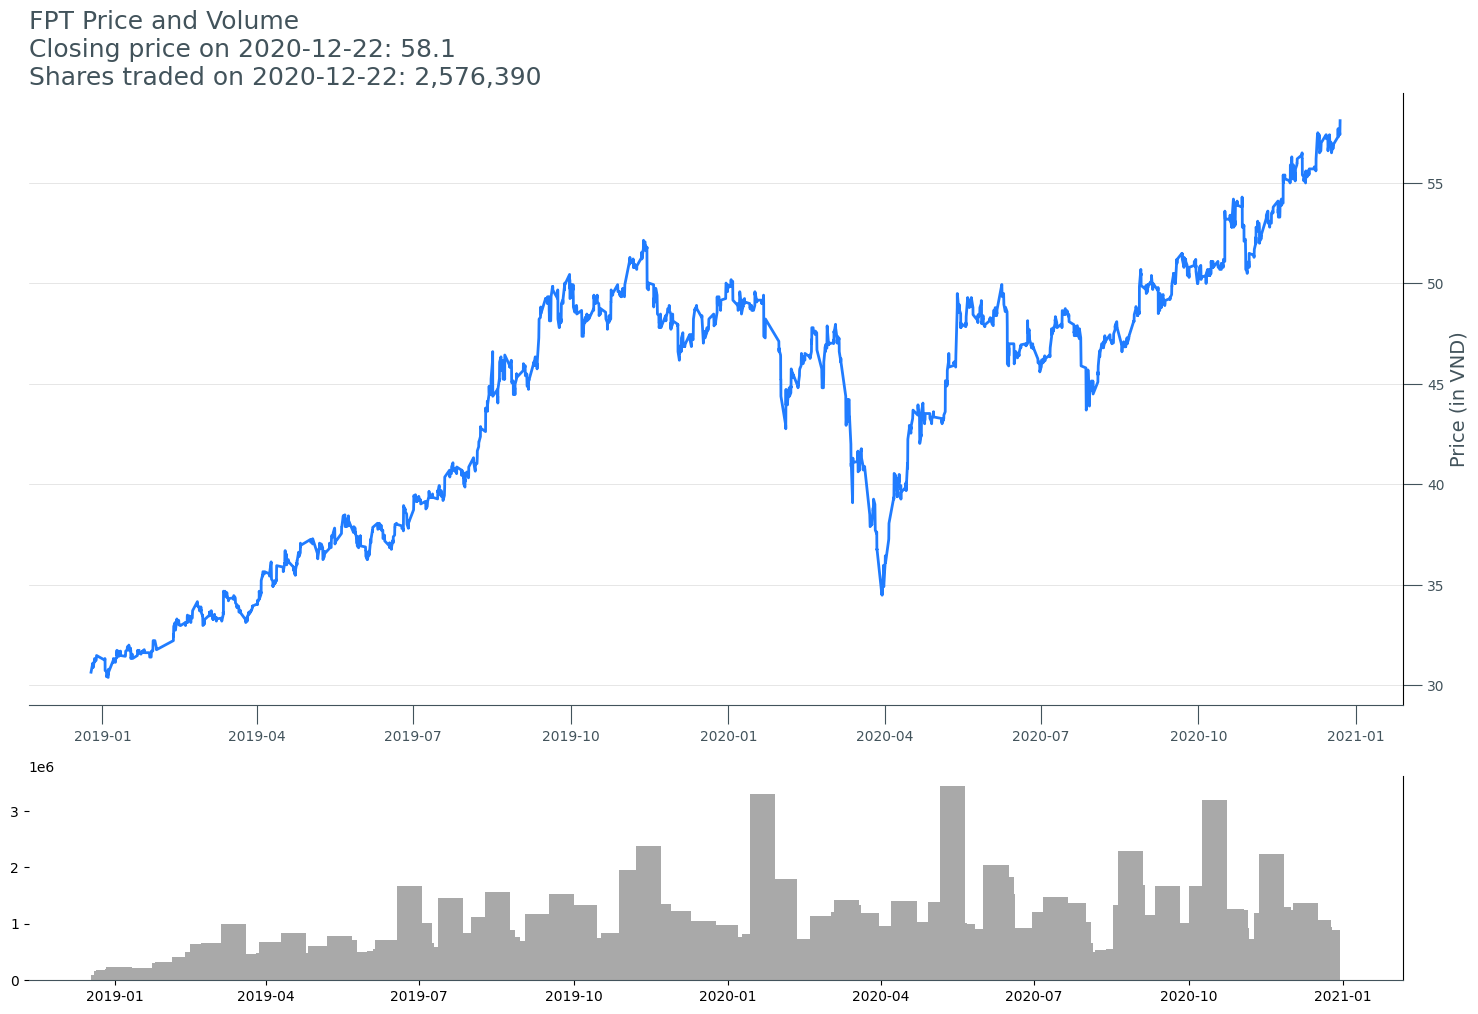

In [ ]:
def format_borders(plot):
    plot.spines['top'].set_visible(False)
    plot.spines['left'].set_visible(False)
    plot.spines['left'].set_color(colors['grey'])
    plot.spines['bottom'].set_color(colors['grey'])

def get_prev_day_info(plot):
    previous_close=str("{:,}".format(date_df['Close'][date_df.shape[0] - 1]))
    previous_volume=str("{:,}".format(date_df['Volume'][date_df.shape[0] - 1]))
    previous_date=str(date_df['Date'][date_df.shape[0] - 1])
    plot.set_title(
        'FPT Price and Volume\n'
        'Closing price on ' + previous_date + ': ' + previous_close  +
        '\nShares traded on ' + previous_date + ': ' + previous_volume,
        fontdict=config_title, loc='left'
    )

def get_charts(stock_data, interval='Date'):
    plt.rc('figure', figsize=(15, 10))

    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
    fig.tight_layout(pad=3)

    date = stock_data[interval]
    close = stock_data['Close']
    vol = stock_data['Volume']

    plot_price = axes[0]
    plot_price.plot(date, close, color=colors['blue'], linewidth=2, label='Price')

    plot_vol = axes[1]
    plot_vol.bar(date, vol, width=15, color='darkgrey')

    plot_price.yaxis.tick_right()
    plot_price.tick_params(axis='both', **config_ticks)
    plot_price.set_ylabel('Price (in VND)', fontsize=14)
    plot_price.yaxis.set_label_position("right")
    plot_price.yaxis.label.set_color(colors['grey'])
    plot_price.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_price.set_axisbelow(True)

    format_borders(plot_price)
    format_borders(plot_vol)

    get_prev_day_info(plot_price)

colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}
config_title = {'size': 18, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}

get_charts(hour_df, 'Date/Hour')

- Bước tiền xử lý tương tự như trên nhưng:
    - Chia train:validation:test là 0.7:0.15:0.15.
    - Sử dụng chuỗi 48 đặt trưng liên tục thay vì 60.

In [ ]:
# We'll use 'Close' column to predict future prices
data_to_use = hour_df[feats].values

# Data normalization
scaler = MinMaxScaler()
data_to_use = scaler.fit_transform(data_to_use.reshape(-1,len(feats)))

# Split data into training and testing sets
train_data , valid_test_data = split_dataset(data_to_use,test_size=0.3)
valid_data , test_data = split_dataset(valid_test_data,test_size=0.5)

# Convert data into suitable format
timestep = 48
x_train , y_train = create_dataset(train_data, timestep)
x_valid , y_valid = create_dataset(valid_data, timestep)
x_test , y_test = create_dataset(test_data, timestep)

# Reshape data to fit into LSTM model
x_train = np.reshape(x_train , (x_train.shape[0] , x_train.shape[1] , 1))
x_valid = np.reshape(x_valid , (x_valid.shape[0] , x_valid.shape[1] , 1))
x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))

[[x_train.shape, y_train.shape], [x_valid.shape, y_valid.shape], [x_test.shape, y_test.shape]]

[[(1695, 48, 1), (1695,)], [(326, 48, 1), (326,)], [(326, 48, 1), (326,)]]

- Model tương tự như trên.

In [ ]:
# Define the LSTM model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(units=128, return_sequences=True))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=64))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define model checkpoint
check_pointer = ModelCheckpoint(filepath='weights_best.hdf5', verbose=2, save_best_only=True)

# Train the model
model.fit(x_train , y_train , epochs=50 , batch_size=32, validation_data=(x_valid, y_valid), callbacks=[check_pointer])

Epoch 1/50
52/53 [============================>.] - ETA: 0s - loss: 0.0126
Epoch 1: val_loss improved from inf to 0.00067, saving model to weights_best.hdf5
53/53 [==============================] - 7s 33ms/step - loss: 0.0124 - val_loss: 6.6831e-04
Epoch 2/50
15/53 [=======>......................] - ETA: 0s - loss: 0.0028

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/53 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 2: val_loss did not improve from 0.00067
53/53 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 8.6064e-04
Epoch 3/50
50/53 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 3: val_loss improved from 0.00067 to 0.00066, saving model to weights_best.hdf5
53/53 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 6.6384e-04
Epoch 4/50
52/53 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 4: val_loss improved from 0.00066 to 0.00054, saving model to weights_best.hdf5
53/53 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 5.3882e-04
Epoch 5/50
49/53 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 5: val_loss did not improve from 0.00054
53/53 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 5.5423e-04
Epoch 6/50
48/53 [==========================>...] - ETA: 0s - loss: 0.0019
Epoch 

- Quá trình định giá tương tự như trên.
- Dữ liệu theo giờ ít hơn theo phút vì vậy kết quả định giá ít chính xác hơn, lệch ~514 đồng với với giá trị thật.

11/11 [==============================] - 1s 4ms/step
0.018559729615606153
0.5141046257884024


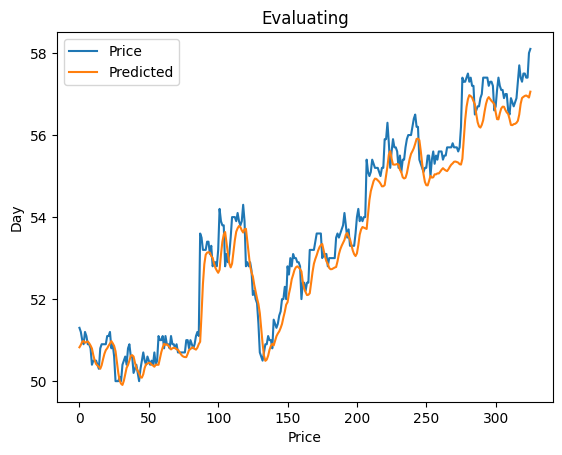

In [ ]:
# Use the model to predict the test data
model = tf.keras.models.load_model('weights_best.hdf5')
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred, squared=False))

# Inverse transform the predicted price data and test data
predicted_price = scaler.inverse_transform(y_pred)
test_price = scaler.inverse_transform(y_test.reshape(-1, 1))
print(mean_squared_error(test_price, predicted_price, squared=False))

plt.rc('figure', figsize=(6.4, 4.8))
plt.title('Evaluating')
plt.xlabel('Price')
plt.ylabel('Day')

plt.plot(test_price, label='Price')
plt.plot(predicted_price, label='Predicted')
plt.legend()

## Mã cổ phiếu FPT (dự đoán theo ngày)

- Hầu hết các ngày đều có từ 100 phút (dữ liệu) trở lên.
- Có ngày 2018-12-25 chỉ có 7 mẫu, vì vậy sẽ bỏ ngày này.

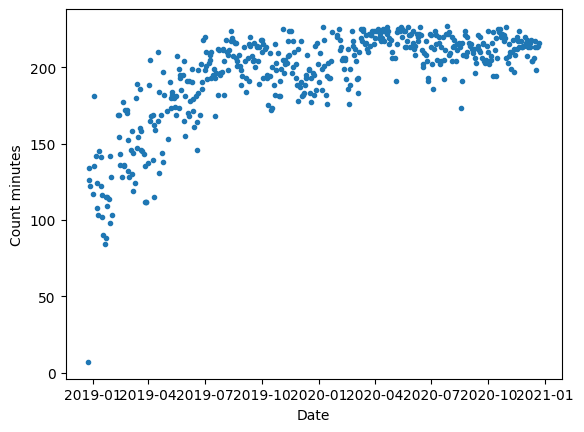

In [ ]:
plt.xlabel('Date')
plt.ylabel('Count minutes')
plt.plot((df.groupby([df['Date/Time'].dt.date])['Volume'].count()), '.')

- Gộp nhóm theo ngày và tạo dataframe mới với:
    - Open là giá của phút đầu tiên theo ngày.
    - High là giá của phút mà cao nhất theo ngày.
    - Low là giá của phút mà thấp nhất theo ngày.
    - Close là giá của phút cuối cùng theo ngày.
    - Volume là tổng thanh khoản theo ngày.

In [ ]:
date_df = pd.DataFrame(df.groupby([df['Date/Time'].dt.date]).aggregate({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume':'sum'}))
date_df.drop([datetime.strptime('2018-12-25', '%Y-%m-%d')], inplace=True)

date_df.index.name = 'Date'
date_df.reset_index(inplace=True)
date_df

,Date,Open,High,Low,Close,Volume
0,2018-12-26,31.04,31.22,30.89,30.89,333590
1,2018-12-27,31.41,31.52,31.19,31.19,454860
2,2018-12-28,31.34,31.49,31.19,31.49,387170
3,2019-01-02,31.19,31.45,30.70,30.74,459120
4,2019-01-03,30.93,30.93,30.37,30.44,716600
...,...,...,...,...,...,...
493,2020-12-16,57.20,57.50,57.00,57.10,1995530
494,2020-12-17,56.90,57.00,56.00,56.50,3594500
495,2020-12-18,56.50,57.00,56.50,56.90,1532820
496,2020-12-21,57.30,57.80,57.10,57.50,2307390


- Trực quan giá và thanh khoản.

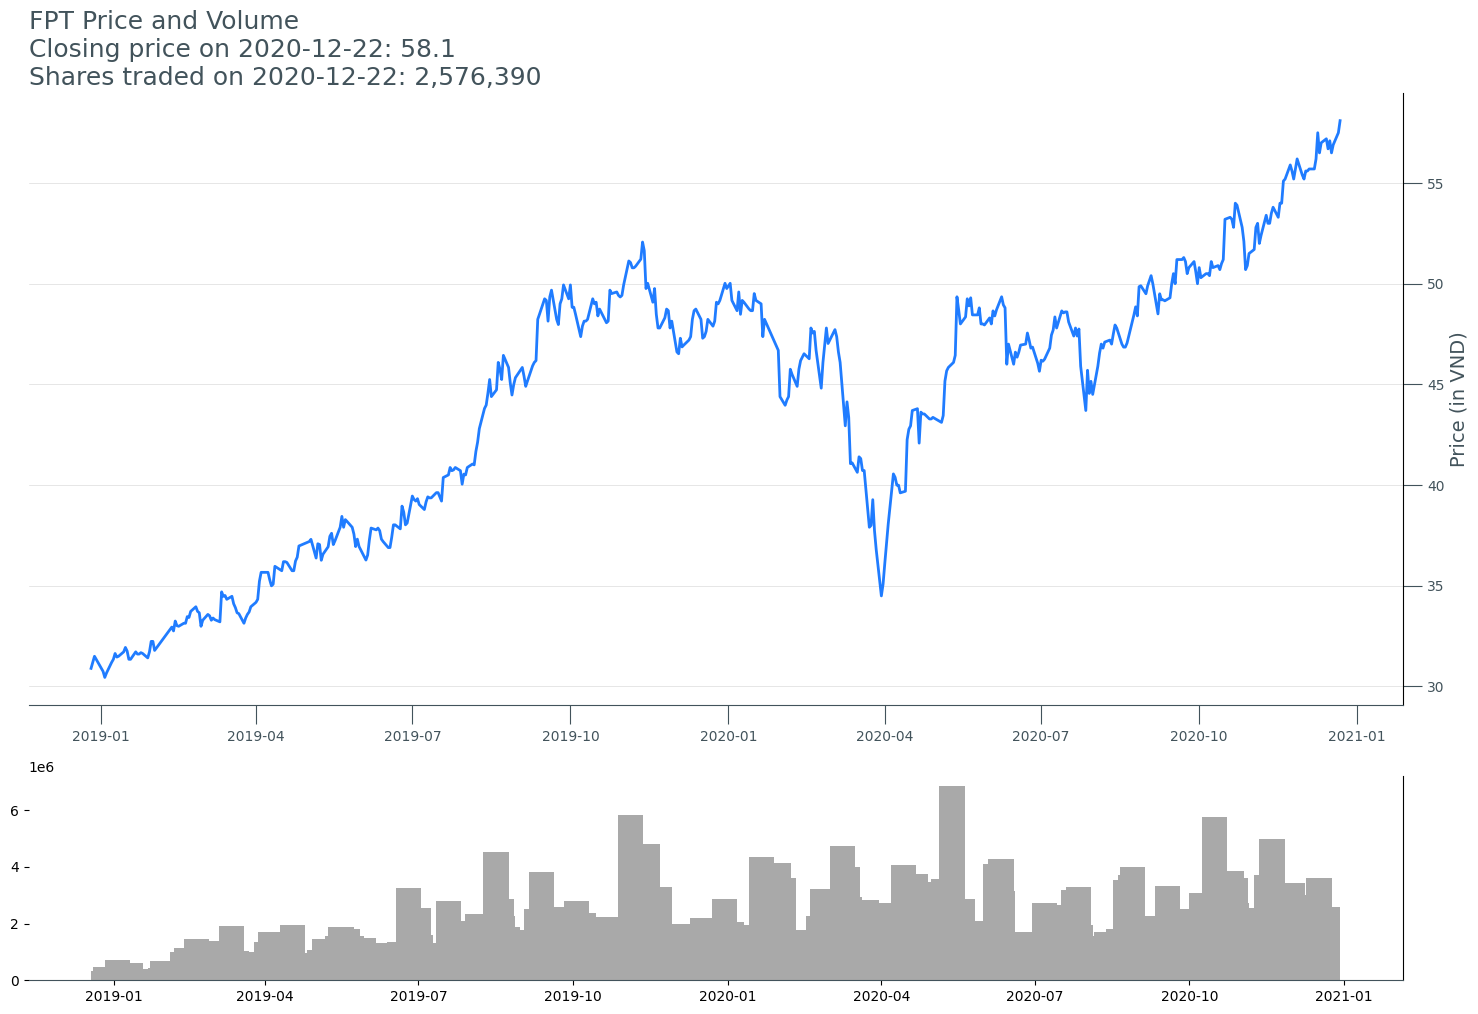

In [ ]:
get_charts(date_df)

- Bước tiền xử lý tương tự như trên nhưng:
    - Chia train:validation:test là 0.75:0.125:0.125.
    - Sử dụng chuỗi 30 đặt trưng liên tục thay vì 60.

In [ ]:
# We'll use 'Close' column to predict future prices
data_to_use = date_df[feats].values

# Data normalization
scaler = MinMaxScaler()
data_to_use = scaler.fit_transform(data_to_use.reshape(-1,len(feats)))

# Split data into training and testing sets
train_data , valid_test_data = split_dataset(data_to_use,test_size=0.25)
valid_data , test_data = split_dataset(valid_test_data,test_size=0.5)

# Convert data into suitable format
timestep = 30
x_train , y_train = create_dataset(train_data, timestep)
x_valid , y_valid = create_dataset(valid_data, timestep)
x_test , y_test = create_dataset(test_data, timestep)

# Reshape data to fit into LSTM model
x_train = np.reshape(x_train , (x_train.shape[0] , x_train.shape[1] , 1))
x_valid = np.reshape(x_valid , (x_valid.shape[0] , x_valid.shape[1] , 1))
x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))

[[x_train.shape, y_train.shape], [x_valid.shape, y_valid.shape], [x_test.shape, y_test.shape]]

[[(343, 30, 1), (343,)], [(32, 30, 1), (32,)], [(33, 30, 1), (33,)]]

- Model tương tự như trên.

In [ ]:
# Define the LSTM model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(units=128, return_sequences=True))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=64))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define model checkpoint
check_pointer = ModelCheckpoint(filepath='weights_best.hdf5', verbose=2, save_best_only=True)

# Train the model
model.fit(x_train , y_train , epochs=50 , batch_size=32, validation_data=(x_valid, y_valid), callbacks=[check_pointer])

Epoch 1/50
 8/11 [====================>.........] - ETA: 0s - loss: 0.0811  
Epoch 1: val_loss improved from inf to 0.02541, saving model to weights_best.hdf5
11/11 [==============================] - 8s 86ms/step - loss: 0.0622 - val_loss: 0.0254
Epoch 2/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.0124
Epoch 2: val_loss improved from 0.02541 to 0.00114, saving model to weights_best.hdf5
11/11 [==============================] - 0s 13ms/step - loss: 0.0124 - val_loss: 0.0011
Epoch 3/50
 1/11 [=>............................] - ETA: 0s - loss: 0.0067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 8/11 [====================>.........] - ETA: 0s - loss: 0.0083
Epoch 3: val_loss did not improve from 0.00114
11/11 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0117
Epoch 4/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.0062
Epoch 4: val_loss did not improve from 0.00114
11/11 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0018
Epoch 5/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.0054
Epoch 5: val_loss did not improve from 0.00114
11/11 [==============================] - 0s 10ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 6/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.0055
Epoch 6: val_loss improved from 0.00114 to 0.00094, saving model to weights_best.hdf5
11/11 [==============================] - 0s 12ms/step - loss: 0.0052 - val_loss: 9.3963e-04
Epoch 7/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.0055
Epoch 7: val_loss did not improve from 0.00094
11/11 

- Quá trình định giá tương tự như trên.
- Dữ liệu theo ngày khá ít (< 500 mẫu) vì vậy kết quả định giá ít chính xác hơn, lệch ~1,105 đồng với với giá trị thật.

2/2 [==============================] - 1s 7ms/step
0.0399595457347413
1.1052806609258807


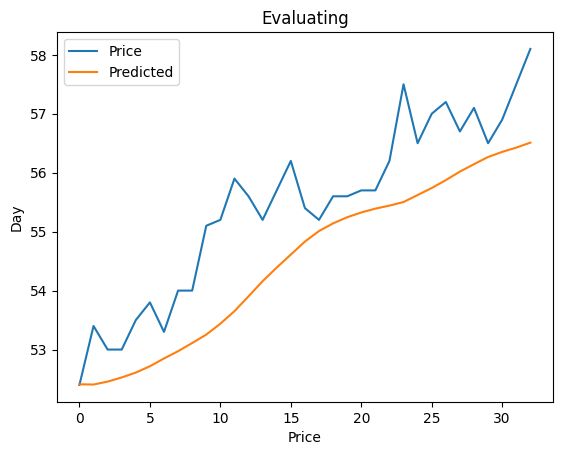

In [ ]:
# Use the model to predict the test data
model = tf.keras.models.load_model('weights_best.hdf5')
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred, squared=False))

# Inverse transform the predicted price data and test data
predicted_price = scaler.inverse_transform(y_pred)
test_price = scaler.inverse_transform(y_test.reshape(-1, 1))
print(mean_squared_error(test_price, predicted_price, squared=False))

plt.rc('figure', figsize=(6.4, 4.8))
plt.title('Evaluating')
plt.xlabel('Price')
plt.ylabel('Day')

plt.plot(test_price, label='Price')
plt.plot(predicted_price, label='Predicted')
plt.legend()

## Mã cổ phiếu VIC (dự đoán theo phút)

*Quá trình modeling, evaluating cũng tương tự như trên và sử dụng cùng kiến trúc LSTM. Và cũng có thể sử dụng mô hình này cho MSN và PNJ.*

In [ ]:
vic_df = pd.read_csv(open('/content/drive/MyDrive/VIC.csv'))
vic_df['Date/Time'] = vic_df['Date/Time'].apply(lambda time: datetime.strptime(time, '%m/%d/%Y %H:%M'))
vic_df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,2018-10-17 09:39:00,98.5,98.5,98.5,98.5,390,0
1,VIC,2018-10-17 09:40:00,98.5,98.5,98.5,98.5,760,0
2,VIC,2018-10-17 09:41:00,98.6,98.6,98.6,98.6,2060,0
3,VIC,2018-10-17 09:42:00,98.6,98.6,98.6,98.6,5540,0
4,VIC,2018-10-17 09:43:00,98.6,98.7,98.6,98.7,760,0
...,...,...,...,...,...,...,...,...
101261,VIC,2020-12-22 14:22:00,105.8,105.8,105.7,105.7,1870,0
101262,VIC,2020-12-22 14:23:00,105.7,105.7,105.7,105.7,2510,0
101263,VIC,2020-12-22 14:24:00,105.7,105.7,105.7,105.7,3620,0
101264,VIC,2020-12-22 14:25:00,105.7,105.7,105.7,105.7,100,0


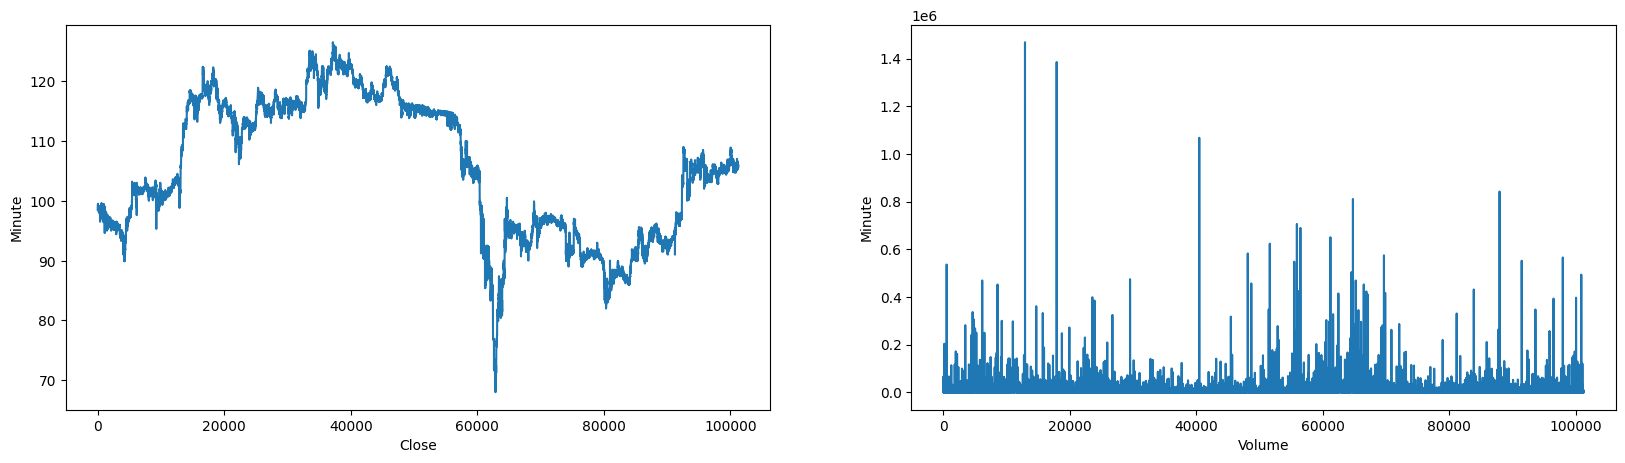

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Close')
plt.ylabel('Minute')
plt.plot(vic_df['Close'])

plt.subplot(1, 2, 2)
plt.xlabel('Volume')
plt.ylabel('Minute')
plt.plot(vic_df['Volume'])

In [ ]:
# We'll use 'Close' column to predict future prices
data_to_use = vic_df[feats].values

# Data normalization
scaler = MinMaxScaler()
data_to_use = scaler.fit_transform(data_to_use.reshape(-1,len(feats)))

# Split data into training and testing sets
train_data , valid_test_data = split_dataset(data_to_use,test_size=0.2)
valid_data , test_data = split_dataset(valid_test_data,test_size=0.5)

# Convert data into suitable format
timestep = 60
x_train , y_train = create_dataset(train_data, timestep)
x_valid , y_valid = create_dataset(valid_data, timestep)
x_test , y_test = create_dataset(test_data, timestep)

# Reshape data to fit into LSTM model
x_train = np.reshape(x_train , (x_train.shape[0] , x_train.shape[1] , 1))
x_valid = np.reshape(x_valid , (x_valid.shape[0] , x_valid.shape[1] , 1))
x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))

[[x_train.shape, y_train.shape], [x_valid.shape, y_valid.shape], [x_test.shape, y_test.shape]]

[[(80952, 60, 1), (80952,)],
 [(10067, 60, 1), (10067,)],
 [(10067, 60, 1), (10067,)]]

In [ ]:
# Define the LSTM model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(units=128, return_sequences=True))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=64))

# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define model checkpoint
check_pointer = ModelCheckpoint(filepath='weights_best.hdf5', verbose=2, save_best_only=True)

# Train the model
model.fit(x_train , y_train , epochs=10 , batch_size=32, validation_data=(x_valid, y_valid), callbacks=[check_pointer])

Epoch 1/10
2524/2530 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 1: val_loss improved from inf to 0.00004, saving model to weights_best.hdf5
2530/2530 [==============================] - 28s 9ms/step - loss: 0.0026 - val_loss: 4.2142e-05
Epoch 2/10
  16/2530 [..............................] - ETA: 18s - loss: 0.0012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2528/2530 [============================>.] - ETA: 0s - loss: 7.0581e-04
Epoch 2: val_loss did not improve from 0.00004
2530/2530 [==============================] - 23s 9ms/step - loss: 7.0563e-04 - val_loss: 5.1725e-05
Epoch 3/10
2530/2530 [==============================] - ETA: 0s - loss: 2.9392e-04
Epoch 3: val_loss improved from 0.00004 to 0.00004, saving model to weights_best.hdf5
2530/2530 [==============================] - 24s 10ms/step - loss: 2.9392e-04 - val_loss: 3.8037e-05
Epoch 4/10
2529/2530 [============================>.] - ETA: 0s - loss: 2.4671e-04
Epoch 4: val_loss did not improve from 0.00004
2530/2530 [==============================] - 25s 10ms/step - loss: 2.4673e-04 - val_loss: 6.9034e-05
Epoch 5/10
2529/2530 [============================>.] - ETA: 0s - loss: 2.3578e-04
Epoch 5: val_loss did not improve from 0.00004
2530/2530 [==============================] - 23s 9ms/step - loss: 2.3582e-04 - val_loss: 4.5721e-04
Epoch 6/10
2528/2530 [============================

315/315 [==============================] - 2s 4ms/step
0.0047071674371048705
0.27536992555784706


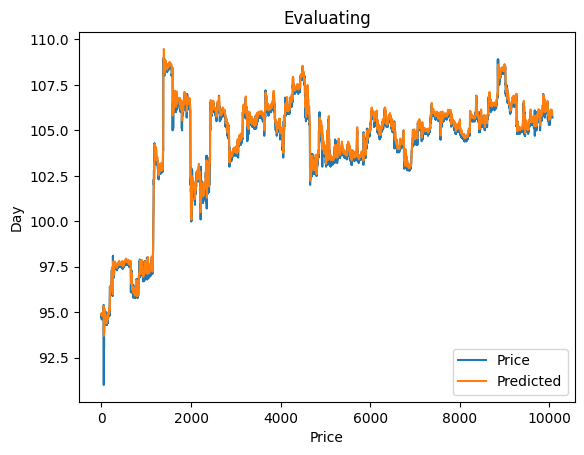

In [ ]:
# Use the model to predict the test data
model = tf.keras.models.load_model('weights_best.hdf5')
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred, squared=False))

# Inverse transform the predicted price data and test data
predicted_price = scaler.inverse_transform(y_pred)
test_price = scaler.inverse_transform(y_test.reshape(-1, 1))
print(mean_squared_error(test_price, predicted_price, squared=False))

plt.title('Evaluating')
plt.xlabel('Price')
plt.ylabel('Day')

plt.plot(test_price, label='Price')
plt.plot(predicted_price, label='Predicted')
plt.legend()